# CVA System Identification: Three Tanks System

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
import statsmodels.api as sm
from time import time
import pandas as pd
import numpy as np
import pickle

## Load the Data Set

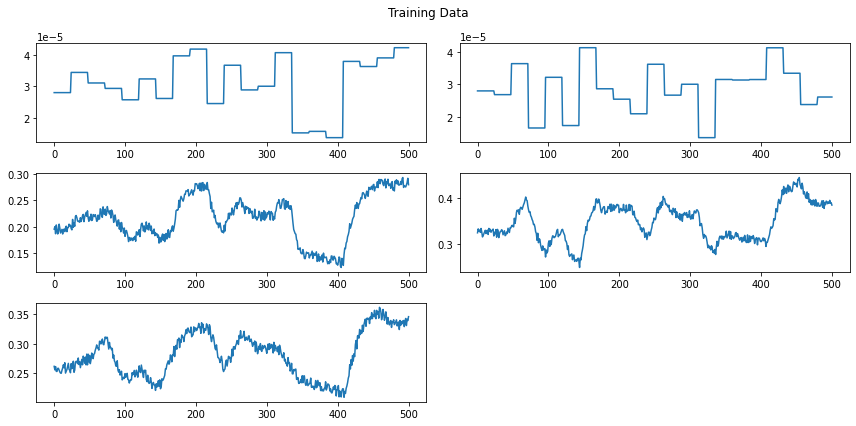

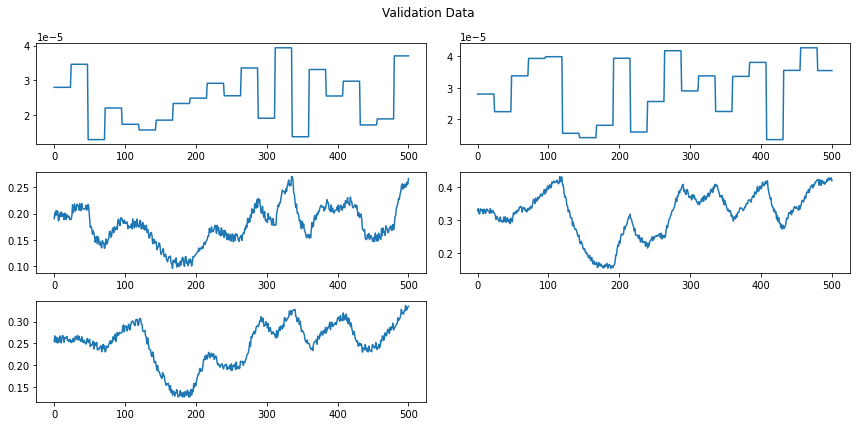

(501, 5)
(501, 5)


In [2]:
tanks_df = pd.read_csv('tanks_seed0_in.csv', index_col=0)
tanks_df2 = pd.read_csv('tanks_seed1_in.csv', index_col=0)

v_name = ['u1', 'u2', 'x1', 'x2', 'x3']
noise_var = np.array([0, 0, 0.02, 0.02, 0.02])

np.random.seed(0)

def prepare_and_plot(tanks_df, noise_var, label):
    plt.figure(figsize=(12, 6))
    ctr = 1
    res = list()
    for j in range(len(v_name)):
        plt.subplot(3,2,ctr)
        data = tanks_df[v_name[j]].values
        data += (np.random.rand(len(data))-0.5)*noise_var[j]
        res.append(data)
        plt.plot(data)
        ctr += 1

    plt.suptitle(label)
    plt.tight_layout()
    plt.show()
    
    return np.transpose(np.vstack(res))

Z_train = prepare_and_plot(tanks_df, noise_var, 'Training Data')
Z_valid = prepare_and_plot(tanks_df2, noise_var, 'Validation Data')
print(Z_train.shape)
print(Z_valid.shape)

## Declare CVA class

In [3]:
class CVA:
    def __init__(self, verbose=None):
        if verbose == None:
            self.verbose = 0
        else:
            self.verbose = verbose
    
    def identify(self, Z_train, UI, YI, n_states=None):
        
        start = time()
        self.UI = UI  # Column indices of input vars 
        self.YI = YI  # Column indices of output vars
        N = Z_train.shape[0]

        # Perform Standard Scaling on raw data [u y]
        sc_raw = StandardScaler()
        Z_train_sc = sc_raw.fit_transform(Z_train)
        y_train = Z_train_sc[:, YI]
        self.sc_raw = sc_raw

        # Calculate the suggested no. of lags on the KPCA scores
        _, ci = sm.tsa.acf(np.sum(y_train ** 2, axis=1), alpha=0.05)
        self.n_lags = np.argwhere(ci[:,0] < 0)[0][0]
        p = f = self.n_lags
        
        # Create Hankel matrices: Yp and Yf from KPCA scores
        Yp, Yf = [], []
        for k in np.arange(N-p-f):
            Yp.append(np.flip(Z_train_sc[k:k+p, :].reshape(-1, 1)))

        for k in np.arange(1, N-p-f+1):
            Yf.append(Z_train_sc[k+p:k+p+f, YI].reshape(-1, 1))

        Yp = np.transpose(np.hstack(Yp))
        Yf = np.transpose(np.hstack(Yf))
        Np = Yp.shape[0]

        # Standardize the Hankel matrices
        sc_p = StandardScaler()
        sc_f = StandardScaler()
        Yp_scaled = sc_p.fit_transform(Yp)
        Yf_scaled = sc_f.fit_transform(Yf)
        self.sc_p = sc_p

        # Perform CCA
        Epp = cholesky(np.dot(Yp_scaled.T, Yp_scaled))  # Past Cholesky matrix
        Eff = cholesky(np.dot(Yf_scaled.T, Yf_scaled))  # Future Cholesky matrix
        Efp = np.dot(Yf_scaled.T, Yp_scaled)            # Cross-covariance matrix
        H = np.linalg.inv(Eff.T) @ Efp @ np.linalg.inv(Epp)

        U, S, V = np.linalg.svd(H)

        # Calculate the suggested no. of states via knee of SV plot
        if n_states == None:
            n_states = np.minimum(2 + np.argmax(np.diff(np.diff(S))), 10)
        self.n_states = n_states

        if self.verbose:
            print(f'No. of lags: {self.n_lags}')
            plt.plot(np.arange(15)+1, S[:15], 'b.--')
            plt.scatter(n_states, S[n_states-1], c='r')
            plt.title('Singular Values plot')
            print(f'No. of states: {n_states}')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # Calculate the state vectors, X
        Vn = np.transpose(V[:n_states, :])
        Jn = np.dot(Vn.T, np.linalg.inv(Epp.T))
        X = Jn @ Yp_scaled.T
        self.Jn = Jn
        
        # Solve for A, B, C, D, K
        M = X.shape[1]
        tk = np.transpose(Z_train_sc[p-1:p+M-1, self.UI])
        yk = np.transpose(y_train[p:p+M, :])

        CD = yk[:,:(M-1)] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                      tk[:,:(M-1)])))
        C = CD[:len(YI), :n_states]          # Output matrix
        D = CD[:len(YI), n_states:]          # Feedthrough matrix

        E = yk[:,:(M-1)] - C @ X[:,:(M-1)] - D @ tk[:,:(M-1)]
        ABK = X[:,1:M] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                   tk[:,:(M-1)], E)))
        A = ABK[:,:n_states]                 # State transition matrix
        B = ABK[:,n_states:(n_states+len(UI))]  # Input matrix
        K = ABK[:,(n_states+len(UI)):]          # Kalman gain
        
        self.ident_time = time() - start     # Time elapsed for identification
        
        self.A, self.B, self.C, self.D, self.K = A, B, C, D, K
        self.X = X
       
    def init_sim(self, Z_test_sc):
        # Calculate initial state x(0) using CVA projection matrix
        yp = np.flip(Z_test_sc[:self.n_lags, :].reshape(1, -1))
        Yp_scaled = self.sc_p.transform(yp)
        x0 = self.Jn @ Yp_scaled.T
        return x0
    
    def simulate(self, Z_test):
        start = time()
        Nt = Z_test.shape[0]
        Z_test_sc = self.sc_raw.transform(Z_test)
        x_pred = np.zeros((self.n_states, Nt - self.n_lags + 1)) 
        y_pred = np.zeros((len(self.YI), Nt - self.n_lags + 1))
        x0 = self.init_sim(Z_test_sc)
        u0 = Z_test_sc[0, self.UI].reshape(-1, 1)
        y0 = self.C @ x0 + self.D @ u0
        x_pred[:, 0] = x0.ravel()
        y_pred[:, 0] = y0.ravel()
        exit_code = 0
        
        for j in np.arange(1, y_pred.shape[1]):
            uk = Z_test_sc[j+self.n_lags-1, self.UI].reshape(-1, 1)
            xk_1 = x_pred[:, j-1].reshape(-1, 1)
            xk = self.A @ xk_1 + self.B @ uk
            yk = self.C @ xk + self.D @ uk
            x_pred[:, j] = xk.ravel()
            y_pred[:, j] = yk.ravel()
            if np.abs(yk).any() > 1e3:
                exit_code = -1
                break
        
        x_pred = np.transpose(x_pred)
        y_pred = np.transpose(y_pred)
        y_pred = (y_pred * self.sc_raw.scale_[self.YI]) + \
                           self.sc_raw.mean_[self.YI]
        self.sim_time = time() - start
        
        return x_pred, y_pred, exit_code
    
    def R2_score(self, Z_test, y_pred):
        r2 = np.zeros(len(self.YI))
        for k in range(len(self.YI)):
            y_true = Z_test[self.n_lags-1:, self.YI[k]]
            r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                    / np.sum((y_true - np.mean(y_true)) ** 2)   
        return r2
    
    def display(self):
        print(f'No. of lags: {self.n_lags}')
        print(f'No. of states: {self.n_states}')
        print(f'Indices of u: {self.UI}')
        print(f'Indices of y: {self.YI}')
        print('State-space matrices:')
        print(self.A)
        print(self.B)
        print(self.C)
        print(self.D)
        print(self.K)

## Identify CVA model from data

No. of lags: 23
No. of states: 4


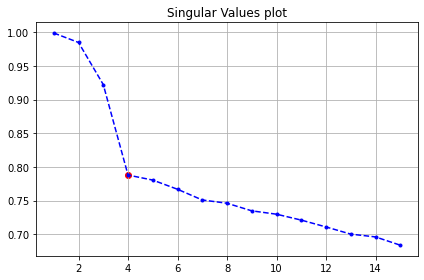

No. of lags: 23
No. of states: 4
Indices of u: [0 1]
Indices of y: [2 3 4]
State-space matrices:
[[ 0.9947871   0.03047495  0.04021139 -0.00807616]
 [ 0.1144794   0.83790398  0.08597082 -0.02302925]
 [-0.14608502 -0.14268046  0.76735191 -0.04900599]
 [ 1.07774068 -0.77916316  0.59993618 -0.41971153]]
[[ 0.0003382  -0.00026071]
 [-0.00927209  0.00304817]
 [ 0.00656984  0.01005615]
 [-0.07144977 -0.00220103]]
[[20.05264763 -8.26083459  1.03782054  0.22667801]
 [17.6943574  10.62513766 -0.80071388 -0.30730121]
 [22.70846559 -1.3364404  -0.21753381 -0.09532836]]
[[-0.04886222  0.02531928]
 [ 0.12318692 -0.04490912]
 [-0.14343279 -0.07339383]]
[[ 0.00074319  0.00213547 -0.00038551]
 [-0.00292811  0.00495703  0.00519309]
 [-0.01160608  0.00026573  0.00706468]
 [-0.0138884   0.00711789  0.00280359]]


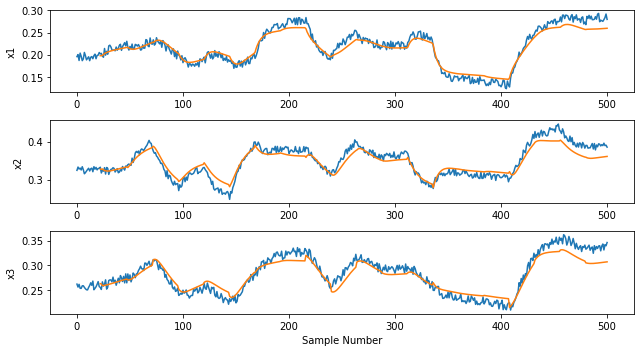

Training Performance
x1 fitness: 92.284%
x2 fitness: 84.188%
x3 fitness: 86.048%
Average:    87.507%
Ident time: 0.50 sec
Sim time:   0.01 sec


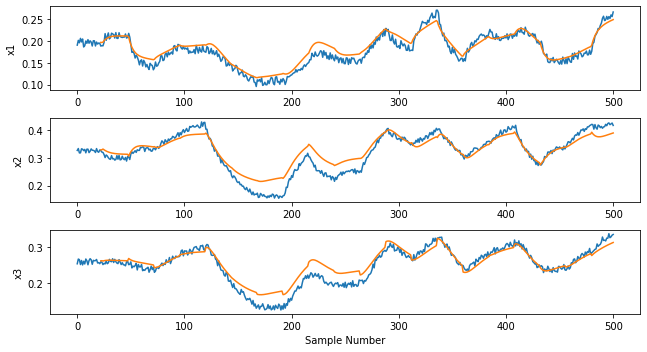

Validation Performance
x1 fitness: 88.212%
x2 fitness: 83.971%
x3 fitness: 84.297%
Average:    85.493%
Ident time: 0.50 sec
Sim time:   0.01 sec


In [4]:
YI, UI = np.array([2, 3, 4]), np.array([0, 1])

sys = CVA(verbose=1)
sys.identify(Z_train, UI, YI)
sys.display()

# Training Performance
x_pred, y_pred, exit_code = sys.simulate(Z_train)
r2 = sys.R2_score(Z_train, y_pred)

plt.figure(figsize=(9, 5))
var_name = ('x1', 'x2', 'x3')
for k in range(len(sys.YI)):
    plt.subplot(3, 1, k+1)
    plt.plot(Z_train[:, sys.YI[k]])
    plt.plot(np.arange(sys.n_lags-1, Z_train.shape[0]), y_pred[:, k])
    plt.ylabel(var_name[k])
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()

print('Training Performance')
print(f"x1 fitness: {r2[0]*100:.3f}%")
print(f"x2 fitness: {r2[1]*100:.3f}%")
print(f"x3 fitness: {r2[2]*100:.3f}%")
print(f"Average:    {np.mean(r2)*100:.3f}%")
print(f"Ident time: {sys.ident_time:.2f} sec")
print(f"Sim time:   {sys.sim_time:.2f} sec")

# Validation Performance
x_pred, y_pred, exit_code = sys.simulate(Z_valid)
r2 = sys.R2_score(Z_valid, y_pred)

plt.figure(figsize=(9, 5))
for k in range(len(sys.YI)):
    plt.subplot(3, 1, k+1)
    plt.plot(Z_valid[:, sys.YI[k]])
    plt.plot(np.arange(sys.n_lags-1, Z_valid.shape[0]), y_pred[:, k])
    plt.ylabel(var_name[k])
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()

print('Validation Performance')
print(f"x1 fitness: {r2[0]*100:.3f}%")
print(f"x2 fitness: {r2[1]*100:.3f}%")
print(f"x3 fitness: {r2[2]*100:.3f}%")
print(f"Average:    {np.mean(r2)*100:.3f}%")
print(f"Ident time: {sys.ident_time:.2f} sec")
print(f"Sim time:   {sys.sim_time:.2f} sec")

In [5]:
with open("tanks_cva_sys.pkl", "wb") as file:
    pickle.dump(sys, file)